In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scFunctions as sf


sc.settings.verbosity = 3

**Loading data and preprocessing**

In [2]:
a = sc.read_h5ad("../data/MERGED_SEU_REANOTATE.h5ad")
a

AnnData object with n_obs × n_vars = 119960 × 25572
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new'
    var: 'features'

In [3]:
sc.pp.filter_cells(a, min_genes=200)
sc.pp.filter_genes(a, min_cells=3)

filtered out 492 genes that are detected in less than 3 cells


In [4]:
a.var['mt'] = a.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

**On ne selectionne que les cellules saines et ES**

In [5]:
adata = a[a.obs['Stage'].isin(["Early_Stages", "Healthy"]), :].copy()
adata

AnnData object with n_obs × n_vars = 76431 × 25080
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
adata = sf.pp_PCA(adata) # Function defined in scFunction.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


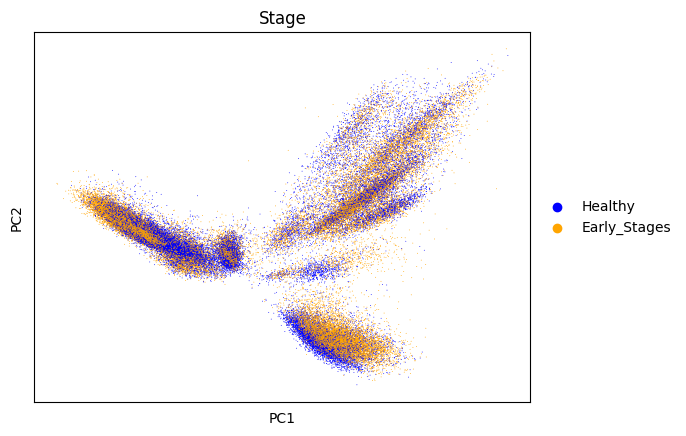

In [7]:
Stage=['Healthy','Early_Stages']
adata.obs['Stage']=pd.Categorical(
    values=adata.obs.Stage, categories=Stage, ordered=True)

sc.pl.pca(adata, color = "Stage", palette={"Healthy" : "blue", "Early_Stages" : "orange"})

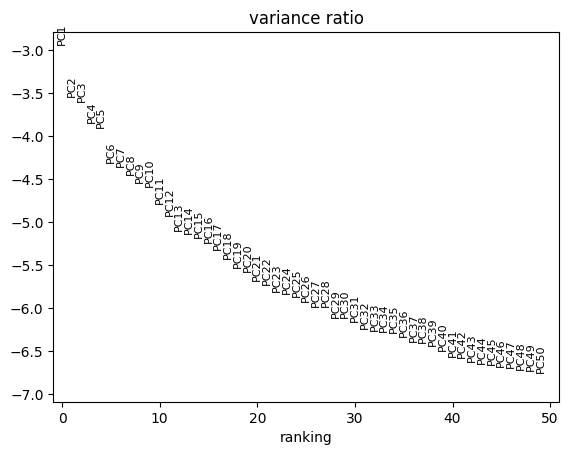

In [8]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) #ndim = 30

In [9]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:12)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


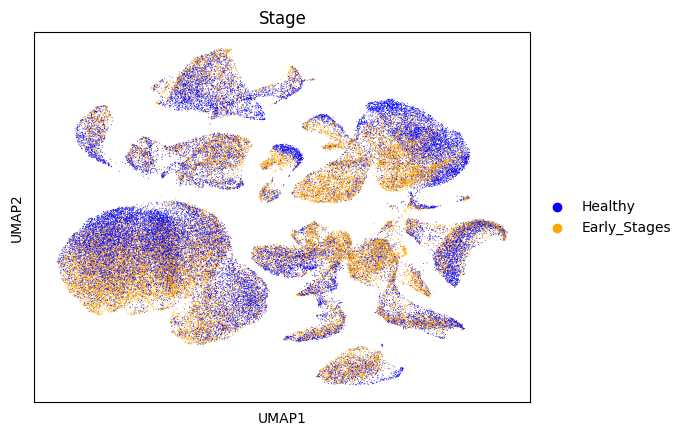

In [10]:
sc.pl.umap(adata, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


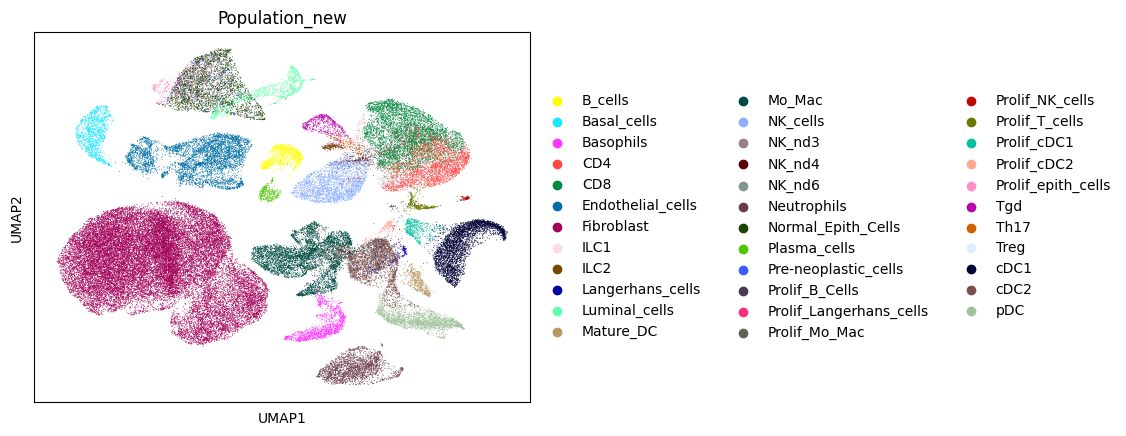

In [11]:
sc.pl.umap(adata, color = "Population_new")

**Calcul les DEG entre ES et H pour toutes les cellules**

In [12]:
sc.tl.rank_genes_groups(adata, "Stage", method = 't-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


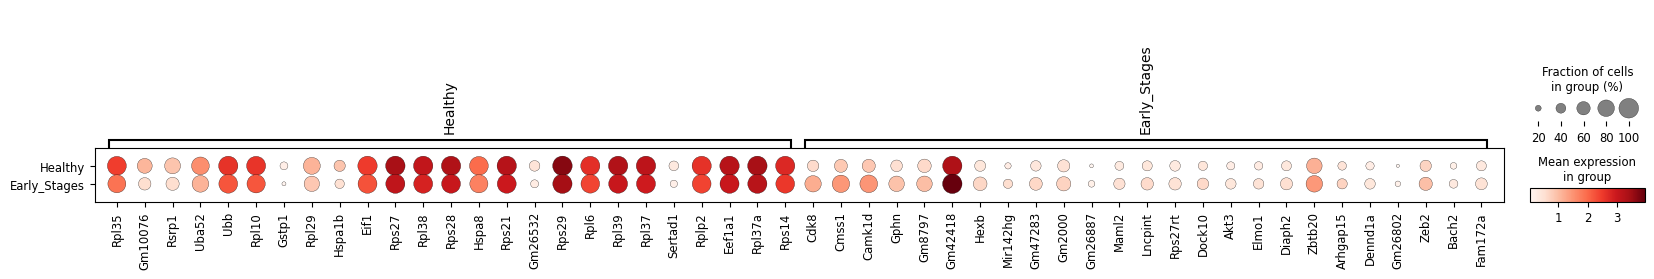

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=25)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Stage']`


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


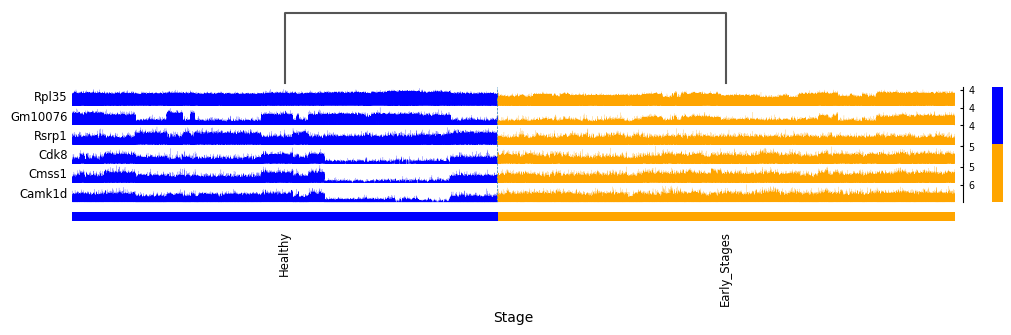

In [14]:
sc.pl.rank_genes_groups_tracksplot(adata, n_genes=3)

Cdk8 et Cmss1 qui sortent

**Sur la UMAP les B semblaient bien se séparer en 2 groupes en fonction du Stage on va donc regarder ça en detail**

In [15]:
adata_B = adata[adata.obs["Population_new"].isin(["B_cells"]), :].raw.to_adata().copy()
adata_B

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


AnnData object with n_obs × n_vars = 1096 × 25080
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'Population_new_colors', 'rank_genes_groups', 'dendrogram_Stage'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [16]:
adata_B = sf.pp_PCA(adata_B) # Function defined in scFunction.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


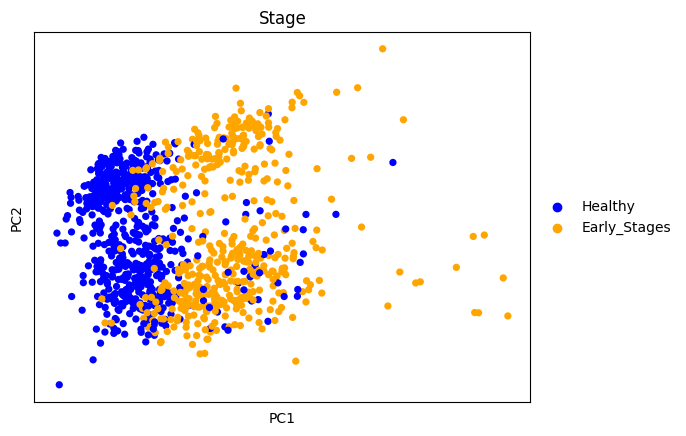

In [17]:
sc.pl.pca(adata_B, color = "Stage")

PCA promettrice

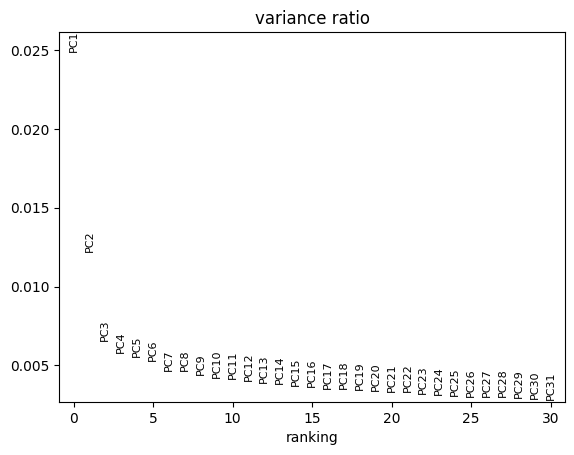

In [18]:
sc.pl.pca_variance_ratio(adata_B) # ndim = 10

In [19]:
sc.pp.neighbors(adata_B, n_pcs=10)
sc.tl.umap(adata_B)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


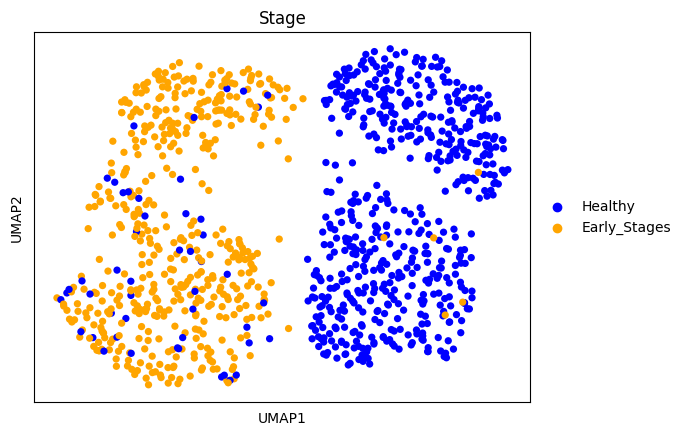

In [20]:
sc.pl.umap(adata_B, color = 'Stage')

In [21]:
sc.tl.rank_genes_groups(adata_B, "Stage")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


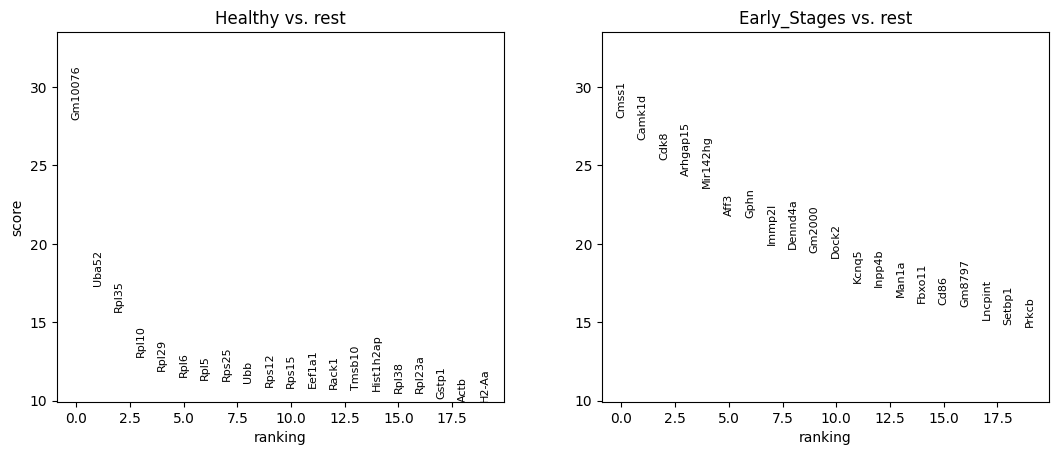

In [22]:
sc.pl.rank_genes_groups(adata_B)

Encore une fois Cmss1n Camk1d et Cdk8 qui sortent

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


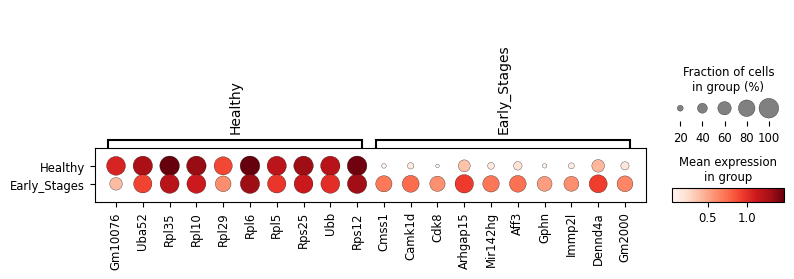

In [23]:
sc.pl.rank_genes_groups_dotplot(adata_B)

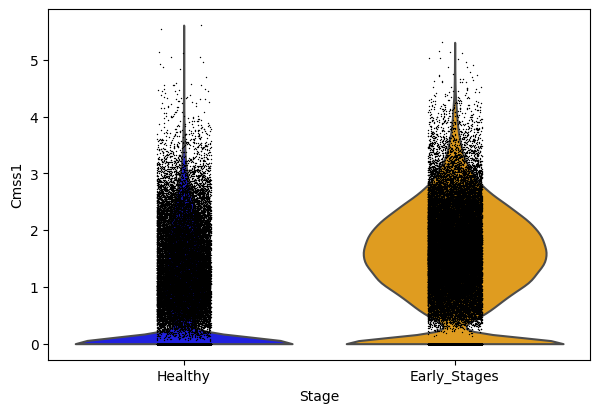

In [24]:
sc.pl.violin(adata, "Cmss1", groupby="Stage")

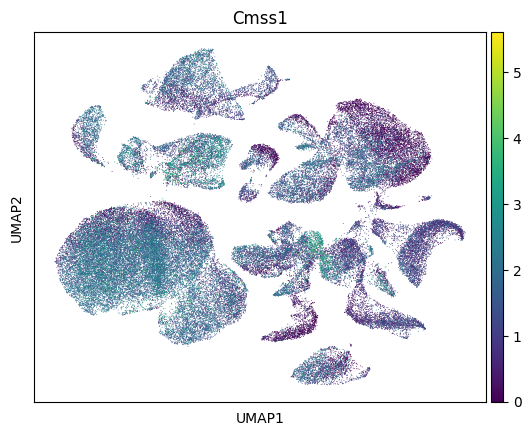

In [25]:
sc.pl.umap(adata, color = "Cmss1")

computing density on 'umap'
--> added
    'umap_density_Stage', densities (adata.obs)
    'umap_density_Stage_params', parameter (adata.uns)


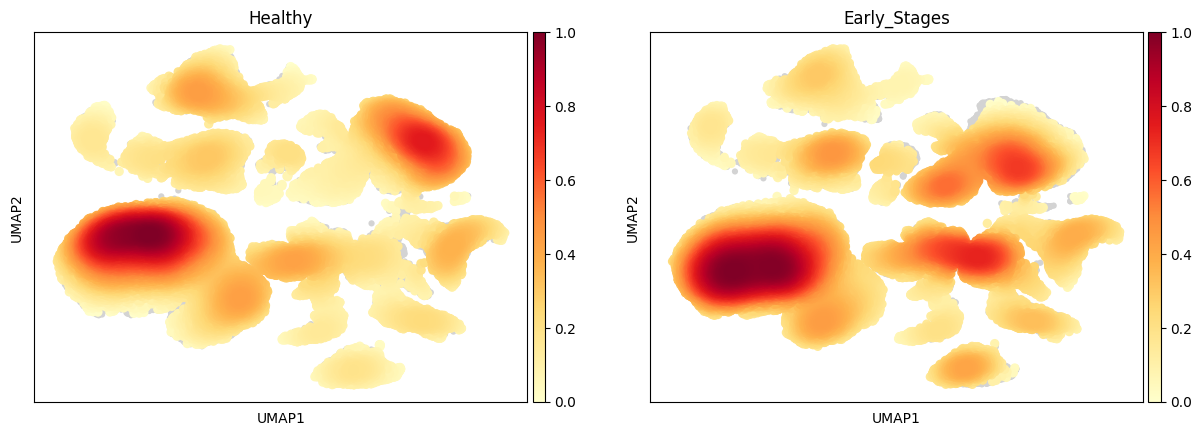

In [26]:
sc.tl.embedding_density(adata, groupby="Stage")
sc.pl.embedding_density(adata, groupby="Stage")

**J'ai envie de modifier l'échelle de l'expression du gène pour qu'elle ressemble à celle du graph de densité**

In [27]:
gene = "Cmss1"
row = adata.raw[:,gene].X.todense()

row_percent = row/max(row)

adata.obs[f"{gene}_percent"] = row_percent

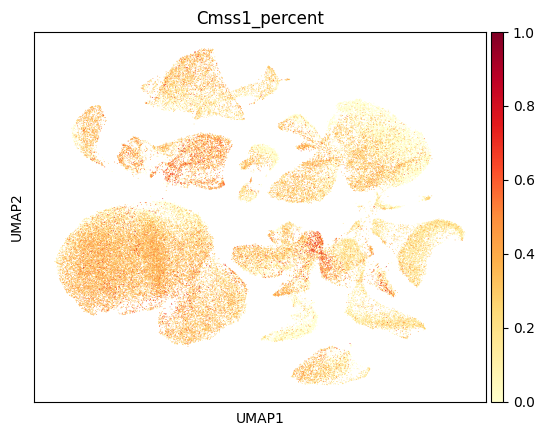

In [28]:
sc.pl.umap(adata, color = "Cmss1_percent", cmap = 'YlOrRd')

Marche pas trop je vais essayer une autre méthode (faire 1 catégorie > median et < median d'expression puis de faire un density plot)

In [29]:
Stage=['Early_Stages','Healthy']
adata.obs['Stage']=pd.Categorical(
    values=adata.obs.Stage, categories=Stage, ordered=True)

In [30]:
gene = "Cmss1"
row = adata.raw[:,gene].X.todense()

row_percent = []
med = np.percentile(list(row), 50)
for i in row:
    if i > med:
        row_percent.append('High')
    else:
        row_percent.append('Low')


adata.obs[f"{gene}_percent"] = row_percent

In [31]:
adata.obs[f"{gene}_percent"] = adata.obs[f"{gene}_percent"].astype("category")

computing density on 'umap'
--> added
    'umap_density_Cmss1_percent', densities (adata.obs)
    'umap_density_Cmss1_percent_params', parameter (adata.uns)


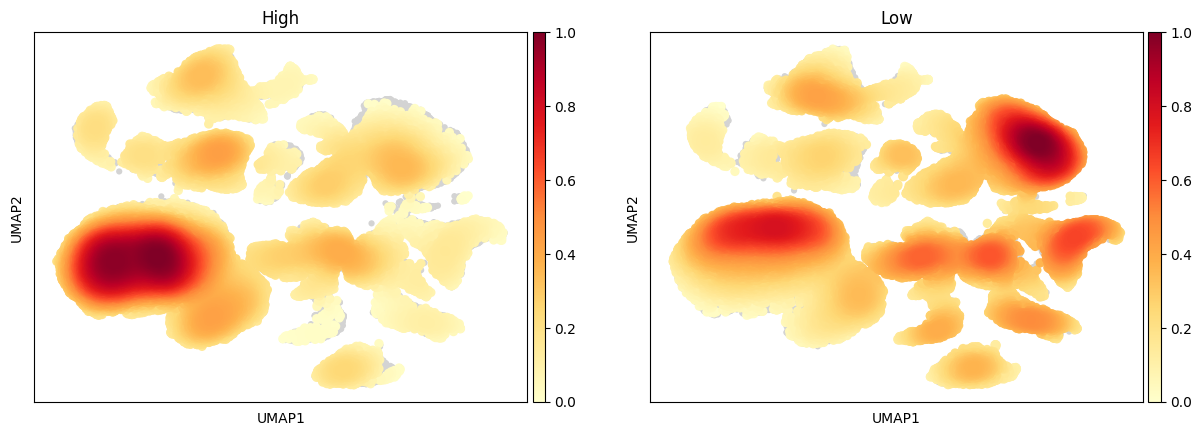

In [32]:
sc.tl.embedding_density(adata, groupby=f"{gene}_percent")
sc.pl.embedding_density(adata, groupby=f"{gene}_percent")

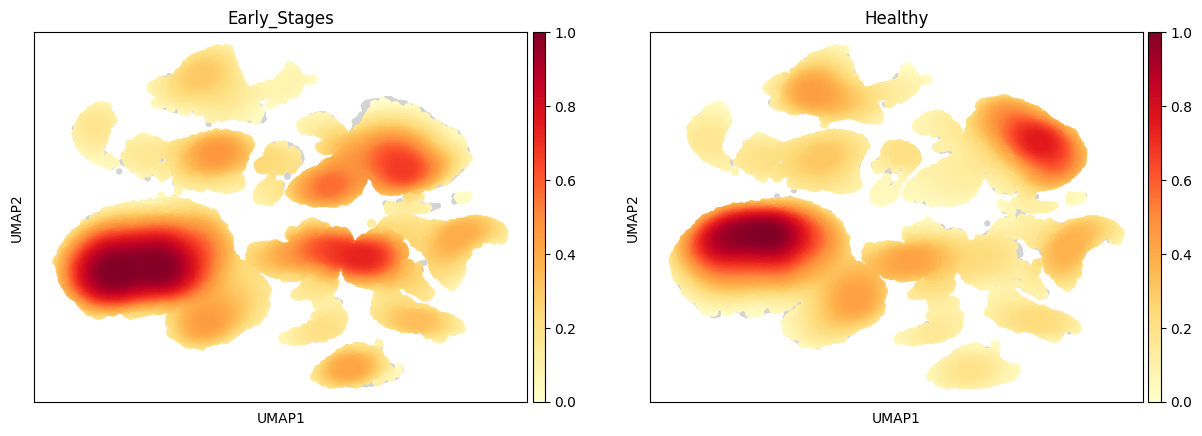

In [33]:
sc.pl.embedding_density(adata, groupby="Stage")

ça a l'air plutot convaincant je vais généraliser à plusieurs gènes


--> Ajout d'une fonction dans scFunctions.py

____ Computing embedding density ____
computing density on 'umap'
--> added
    'umap_density_Cdk8_percent', densities (adata.obs)
    'umap_density_Cdk8_percent_params', parameter (adata.uns)


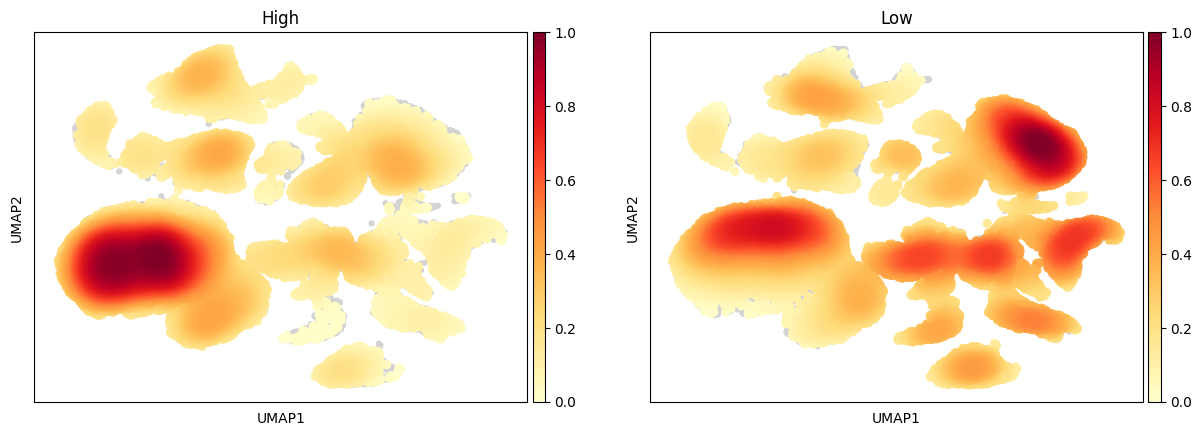

0

In [34]:
sf.embedding_density_gene(adata, "Cdk8")

____ Computing embedding density ____
computing density on 'umap'
--> added
    'umap_density_Camk1d_percent', densities (adata.obs)
    'umap_density_Camk1d_percent_params', parameter (adata.uns)


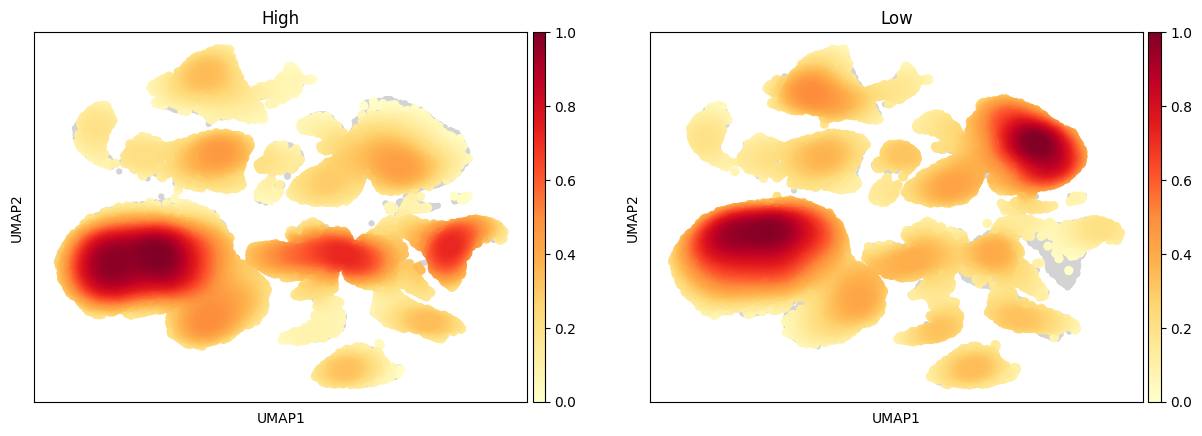

0

In [35]:
sf.embedding_density_gene(adata, "Camk1d")